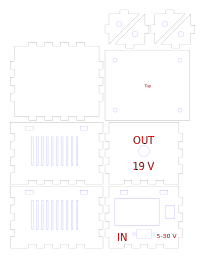

In [6]:
from IPython.display import SVG, display

import io
import sys

sys.path.append('..')  # uncomments and adjust if your Boxes.py copy in not in the Python path
from boxes import *
from boxes.lids import LidSettings


class StepUpDownConverterBox(Boxes):
    """A simple Box"""

    description = "This box is kept simple on purpose. If you need more features have a look at the UniversalBox."

    ui_group = "Box"

    def __init__(self) -> None:
        Boxes.__init__(self)
        self.addSettingsArgs(edges.FingerJointSettings)
        self.addSettingsArgs(LidSettings)
        self.buildArgParser("x", "y", "h", "outside", "bottom_edge")
        self.argparser.add_argument(
            "--triangle", action="store", type=float, default=30.,
            help="Sides of the triangles holding the lid in mm")
        self.argparser.add_argument(
            "--d1", action="store", type=float, default=4.2,
            help="Diameter of the inner lid screw holes in mm")

    def wall_ventilation(self):
        x_step, hole_width = 5, 1.5
        nc = 10
        offset = (self.x - nc * x_step + hole_width) / 2
        for i in range(nc):
            self.rectangularHole(offset + i * x_step, self.h / 2, hole_width, self.h / 2)
        t = self.thickness
        self.fingerHolesAt(0, self.h - 1.5 * t, self.triangle, 0)
        self.fingerHolesAt(self.x, self.h - 1.5 * t, self.triangle, 180)

    def front_wall(self):
        display_length = 45
        display_height = 26.5
        rocker_l = 13.8
        rocker_w = 8.9
        xt60_l = 15.75
        xt60_h = 8.2
        xt60_x, xt60_y = self.y / 2, 10
        xt60_hole_offset = 10
        xt60_hole_radius = 2.6 / 2
        y_display = 32
        self.rectangularHole(28, y_display, display_length, display_height)
        self.rectangularHole(61, y_display, rocker_w, rocker_l)
        self.rectangularHole(xt60_x, xt60_y, xt60_l, xt60_h)
        self.hole(xt60_x - xt60_hole_offset, xt60_y, xt60_hole_radius)
        self.hole(xt60_x + xt60_hole_offset, xt60_y, xt60_hole_radius)
        self.text("IN", 13, 8, align="middle center", color=Color.ANNOTATIONS, fontsize=10)
        self.text("5-30 V", 58, 9, align="middle center", color=Color.ANNOTATIONS, fontsize=6)
        t = self.thickness
        self.fingerHolesAt(0, self.h - 1.5 * t, self.triangle, 0)
        self.fingerHolesAt(self.y, self.h - 1.5 * t, self.triangle, 180)

    def back_wall(self):
        DC55_21_diam = 11
        self.hole(self.y / 2, self.h / 2, DC55_21_diam / 2)
        self.text("OUT", self.y / 2, self.h / 2 + 12, align="middle center", color=Color.ANNOTATIONS, fontsize=10)
        self.text("19 V", self.y / 2, self.h / 2 - 14, align="middle center", color=Color.ANNOTATIONS, fontsize=10)

    def render(self):
        x, y, h = self.x, self.y, self.h

        t1, t2, t3, t4 = "eeee"
        b = self.edges.get(self.bottom_edge, self.edges["F"])
        sideedge = "F" # if self.vertical_edges == "finger joints" else "h"

        trh = self.triangle / 3.

        if self.outside:
            self.x = x = self.adjustSize(x, sideedge, sideedge)
            self.y = y = self.adjustSize(y)
            self.h = h = self.adjustSize(h, b, t1)

        with self.saved_context():
            self.rectangularWall(x, h, [b, sideedge, t1, sideedge],
                                 ignore_widths=[1, 6], move="up", callback=[self.wall_ventilation])
            self.rectangularWall(x, h, [b, sideedge, t3, sideedge],
                                 ignore_widths=[1, 6], move="up", callback=[self.wall_ventilation])

            if self.bottom_edge != "e":
                self.rectangularWall(x, y, "ffff", move="up")
            self.lid(x, y)

        self.rectangularWall(x, h, [b, sideedge, t3, sideedge],
                             ignore_widths=[1, 6], move="right only")
        self.rectangularWall(y, h, [b, "f", t2, "f"],
                             ignore_widths=[1, 6], move="up", callback=[self.front_wall])
        self.rectangularWall(y, h, [b, "f", t4, "f"],
                             ignore_widths=[1, 6], move="up", callback=[self.back_wall])
        self.rectangularWall(x, y, callback=[lambda:self.hole(trh, trh, d=self.d1)] * 4, move='up', label="Top")

        # Triangles
        self.rectangularTriangle(self.triangle, self.triangle, "ffe", num=4,
            callback=[None, lambda: self.hole(trh, trh, d=5.7)])

thickness = 4.0
x = 85
y = 70
z = 58

file_format = "svg"

b = StepUpDownConverterBox()
b.parseArgs(['--reference=0', f'--format={file_format}', '--debug=0', f'--thickness={thickness}', '--bottom_edge=F',
             f'--x={x}', f'--y={y}', f'--h={z}', '--outside=0', '--burn=0.05'])
# b.parseArgs()
b.open()
b.render()
data = b.close()

# pstoedit required

with open(f'{b.__class__.__name__}.{file_format}', "wb") as f:
    if isinstance(data, io.BufferedReader):
        # dxf
        f.write(data.read())
    else:
        # svg
        f.write(data.getbuffer())

if file_format == "svg":
    display(SVG(data=data.getvalue()))